In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    accuracy_score, recall_score, precision_score,
    f1_score, confusion_matrix, make_scorer,
    classification_report, r2_score
)
from scipy.stats import ttest_rel
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Carregar o ficheiro CSV
df = pd.read_csv(r"C:\Users\joaoe\Downloads\AIRPOL_data (3).csv", sep=';', decimal = ',')

# Eliminar colunas totalmente vazias
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Selecionar as colunas num√©ricas
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calcular o IQR e remover outliers
for col in numeric_cols:
    Q1 = df[col].quantile(0.10)
    Q3 = df[col].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filtrar para valores dentro dos limites
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print(f"O dataframe final tem {df.shape[0]} registos e {df.shape[1]} colunas.")

# eliminar linhas com missing values
df.dropna(inplace=True)
df.drop_duplicates(inplace=True) # a apagar cerca de 4000 registos

df = df.drop(columns=['NUTS_Code'], errors='ignore')

# 5. One-Hot Encoding para colunas categ√≥ricas nominais
categorical_cols = ['Air_Pollutant', 'Outcome']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

O dataframe final tem 40900 registos e 8 colunas.


In [2]:
## 4.2 Regress√£o ##

df_copy = df.copy()



# Filtrar apenas os pa√≠ses de Southern Europe:
# Southern Europe: Greece, Spain, Italy, Portugal
paises_sul_europa = ['Greece', 'Spain', 'Italy', 'Portugal']
df_southern = df[df['Country'].isin(paises_sul_europa)].copy()

In [3]:
# 4.2.1 Diagrama de correla√ß√£o entre Premature_deaths e restantes atributos

# Selecionar colunas num√©ricas para calcular correla√ß√£o

colunas_numericas = df_southern.select_dtypes(include=[np.number]).columns.tolist()

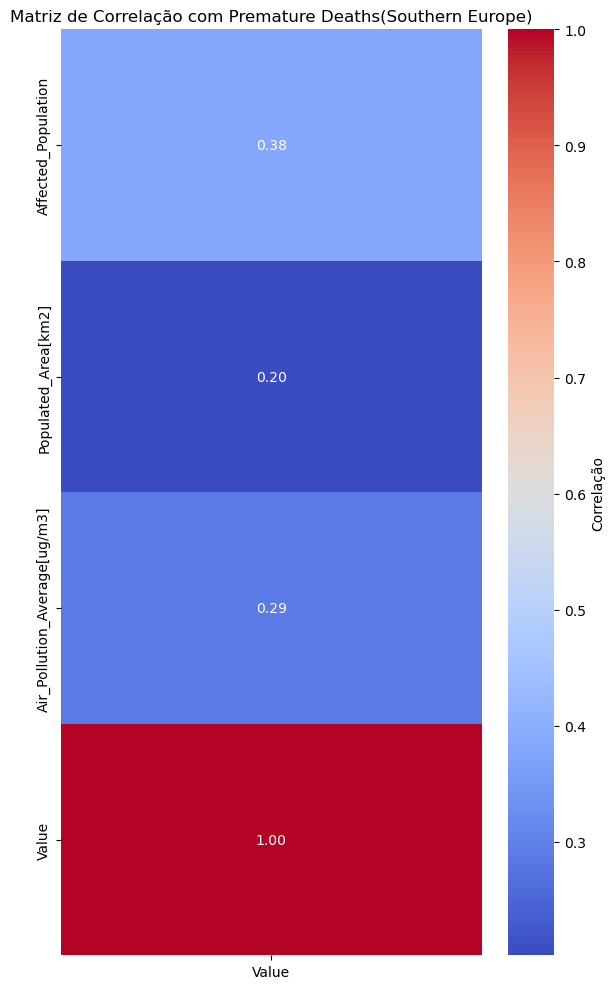

In [4]:
# Calcular matriz de correla√ß√£o 
corr_matrix = df_southern[colunas_numericas].corr()


# Mostrar heatmap da matriz de correla√ß√£o completa para contextualiza√ß√£o
plt.figure(figsize=(6, 10))
sns.heatmap(corr_matrix[['Value']], annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correla√ß√£o'})
plt.title('Matriz de Correla√ß√£o com Premature Deaths(Southern Europe)')
plt.tight_layout()
plt.show()




Fold 1: MAE = 96.8618, RMSE = 144.5532
Fold 2: MAE = 98.0678, RMSE = 148.7003
Fold 3: MAE = 98.6483, RMSE = 146.1064
Fold 4: MAE = 101.8563, RMSE = 154.5138
Fold 5: MAE = 101.1930, RMSE = 157.1186

===== Resultados (K-Fold = 5) =====
MAE m√©dio nos folds:   99.3254
RMSE m√©dio nos folds:  150.1985
-----
MAE global (todos os pontos):   99.3249
RMSE global (todos os pontos):  150.2756

Fun√ß√£o linear final (ajustada em todo o dataset):
Premature_Deaths = 55.0546 + 0.0001 * Affected_Population


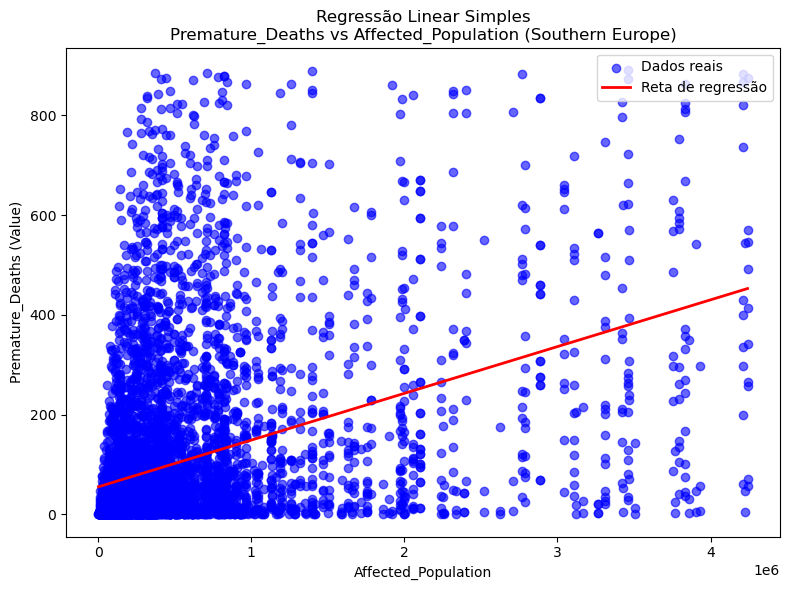

In [5]:
# 4.2.2 Modelo de regress√µa linear simples para prever a vari√°vel Premature_Deaths com base na vari√°vel Affected_Population

# Preparar X e y

#    X = Affected_Population, y = Value (Premature_Deaths)
X = df_southern[['Affected_Population']].values  # formato (n_samples, 1)
y = df_southern['Value'].values                   # formato (n_samples,)


# Configurar K-Fold Cross-Validation (k = 5)
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Listas para armazenar erros de cada fold
mae_folds = []
rmse_folds = []

# Vamos tamb√©m coletar as previs√µes para cada √≠ndice de teste, para calcular m√©tricas globais
y_pred_full = np.zeros_like(y)
y_true_full = np.zeros_like(y)


# Loop pelos folds: treinar e avaliar

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    # Dividir treino / teste
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Ajustar modelo de regress√£o linear simples
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Prever no conjunto de teste
    y_pred = model.predict(X_test)
    
    # Armazenar previs√µes para m√©tricas globais
    y_pred_full[test_index] = y_pred
    y_true_full[test_index] = y_test
    
    # Calcular MAE e RMSE para este fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    mae_folds.append(mae)
    rmse_folds.append(rmse)
    
    print(f"Fold {fold_index + 1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")


# Erros M√©dios nos k Folds + Erro ‚ÄúGlobal‚Äù usando y_pred_full vs y_true_full
mae_media = np.mean(mae_folds)
rmse_media = np.mean(rmse_folds)

mae_global = mean_absolute_error(y_true_full, y_pred_full)
rmse_global = np.sqrt(mean_squared_error(y_true_full, y_pred_full))

print("\n===== Resultados (K-Fold = 5) =====")
print(f"MAE m√©dio nos folds:   {mae_media:.4f}")
print(f"RMSE m√©dio nos folds:  {rmse_media:.4f}")
print(f"-----")
print(f"MAE global (todos os pontos):   {mae_global:.4f}")
print(f"RMSE global (todos os pontos):  {rmse_global:.4f}")

# Ajustar modelo final em todo o conjunto para obter a fun√ß√£o linear
final_model = LinearRegression()
final_model.fit(X, y)

intercepto = final_model.intercept_
coef = final_model.coef_[0]

print("\nFun√ß√£o linear final (ajustada em todo o dataset):")
print(f"Premature_Deaths = {intercepto:.4f} + {coef:.4f} * Affected_Population")



# Visualizar diagrama de dispers√£o + reta de regress√£o

plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.6, label='Dados reais')

# Criar uma sequ√™ncia de valores de Affected_Population para plotar a reta
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = final_model.predict(x_line)

plt.plot(x_line, y_line, color='red', linewidth=2, label='Reta de regress√£o')
plt.title('Regress√£o Linear Simples\nPremature_Deaths vs Affected_Population (Southern Europe)')
plt.xlabel('Affected_Population')
plt.ylabel('Premature_Deaths (Value)')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# 4.2.3 Modelos para prever a vari√°vel Premature_Deaths

k = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

base_features = [
    'Affected_Population',
    'Air_Pollution_Average[ug/m3]',
    'Populated_Area[km2]'
]
encoded_features = [
    col for col in df.columns
    if col.startswith('Air_Pollutant_') or col.startswith('Outcome_')
]
features = base_features + encoded_features

# Preparar X e y
# X = todas as features (df_southern[features]), y = df_southern['Value'] (Premature_Deaths)
X = df_southern[features].values       # formato (n_samples, n_features)
y = df_southern['Value'].values        # formato (n_samples,)

# Normaliza√ß√£o para todos os modelos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


==== a) Regress√£o Linear M√∫ltipla ====

Fold 1: MAE = 88.2129, RMSE = 131.9362
Fold 2: MAE = 87.3470, RMSE = 135.6508
Fold 3: MAE = 88.9381, RMSE = 132.6226
Fold 4: MAE = 93.2106, RMSE = 141.9815
Fold 5: MAE = 91.7508, RMSE = 141.7620

===== Resultados Regress√£o Linear M√∫ltipla (K-Fold = 5) =====
MAE m√©dio nos folds:   89.8919
RMSE m√©dio nos folds:  136.7906
-----
MAE global (todos os pontos):   89.8913
RMSE global (todos os pontos):  136.8584

Coeficientes finais (ajustados em todo o dataset):
  Affected_Population: 66.4602
  Air_Pollution_Average[ug/m3]: 36.6221
  Populated_Area[km2]: -4.4288
  Air_Pollutant_NO2: -15.6025
  Air_Pollutant_PM2.5: 15.6025
  Outcome_Asthma: -22.3506
  Outcome_Chronic obstructive pulmonary disease: -3.2307
  Outcome_Diabetes Mellitus: 17.3744
  Outcome_Ischemic heart disease: 0.4909
  Outcome_Lung cancer: -9.2363
  Outcome_Stroke: 12.8370
Intercepto: 100.3481


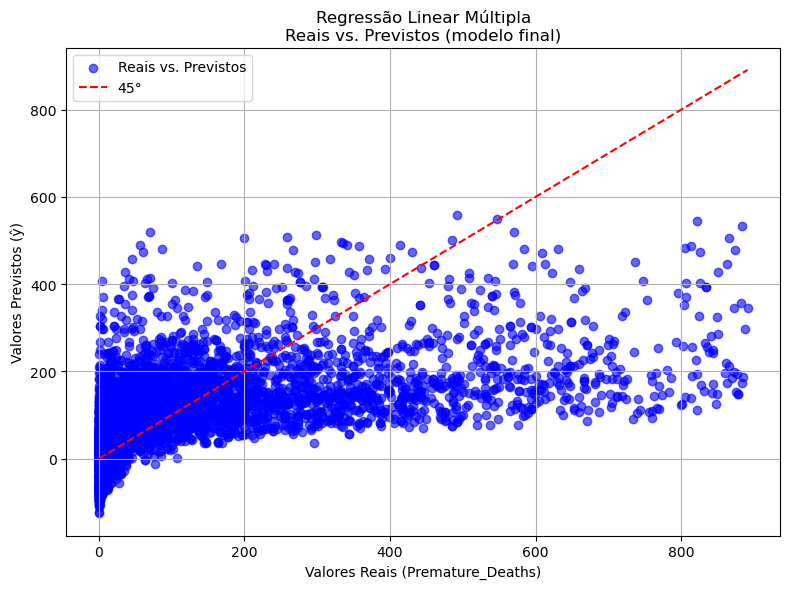

In [7]:
print("==== a) Regress√£o Linear M√∫ltipla ====\n")

# Listas para armazenar o MAE e RMSE de cada fold
mae_folds_lr = []
rmse_folds_lr = []

# Vetores para predi√ß√µes ‚Äúglobais‚Äù
y_pred_full_lr = np.zeros_like(y, dtype=float)
y_true_full_lr = np.zeros_like(y, dtype=float)

# Loop de K-Fold
for fold_index, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    
    # Dividir em treino e teste
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Instanciar e treinar o modelo
    model_lr = LinearRegression()
    model_lr.fit(X_train, y_train)
      #
    # Prever os valores de teste 
    y_pred = model_lr.predict(X_test)
    
    # Armazenar predi√ß√µes para m√©tricas globais
    y_pred_full_lr[test_index] = y_pred
    y_true_full_lr[test_index] = y_test

    # Calcular e guardar MAE e RMSE deste fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_folds_lr.append(mae)
    rmse_folds_lr.append(rmse)

    print(f"Fold {fold_index}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")
    

# M√©tricas m√©dias por fold
mae_media_lr = np.mean(mae_folds_lr)
rmse_media_lr = np.mean(rmse_folds_lr)

# M√©trica ‚Äúglobal‚Äù (todas as predi√ß√µes de valida√ß√£o juntas)
mae_global_lr = mean_absolute_error(y_true_full_lr, y_pred_full_lr)
rmse_global_lr = np.sqrt(mean_squared_error(y_true_full_lr, y_pred_full_lr))

print("\n===== Resultados Regress√£o Linear M√∫ltipla (K-Fold = 5) =====")
print(f"MAE m√©dio nos folds:   {mae_media_lr:.4f}")
print(f"RMSE m√©dio nos folds:  {rmse_media_lr:.4f}")
print("-----")
print(f"MAE global (todos os pontos):   {mae_global_lr:.4f}")
print(f"RMSE global (todos os pontos):  {rmse_global_lr:.4f}")

# Ajustar modelo final em 100% dos dados para obter coeficientes definitivos
final_model_lr = LinearRegression()
final_model_lr.fit(X_scaled, y)
intercepto_lr = final_model_lr.intercept_
coefs_lr = final_model_lr.coef_





print("\nCoeficientes finais (ajustados em todo o dataset):")
for feat, coef in zip(features, coefs_lr):
    print(f"  {feat}: {coef:.4f}")
print(f"Intercepto: {intercepto_lr:.4f}")

# Plot: reais vs. previstos (modelo final)
y_pred_fullmodel_lr = final_model_lr.predict(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_fullmodel_lr, color='blue', alpha=0.6, label='Reais vs. Previstos')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='45¬∞')
plt.xlabel("Valores Reais (Premature_Deaths)")
plt.ylabel("Valores Previstos (≈∑)")
plt.title("Regress√£o Linear M√∫ltipla\nReais vs. Previstos (modelo final)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



==== b) √Årvore de Regress√£o ====

Melhores par√¢metros da √°rvore: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
Fold 1: MAE = 85.3793, RMSE = 135.8059
Fold 2: MAE = 81.4143, RMSE = 134.3579
Fold 3: MAE = 83.7699, RMSE = 133.1878
Fold 4: MAE = 86.5294, RMSE = 141.7298
Fold 5: MAE = 86.6496, RMSE = 139.2555

===== Resultados √Årvore de Regress√£o (K-Fold = 5) =====
MAE m√©dio nos folds:   84.7485
RMSE m√©dio nos folds:  136.8674
-----
MAE global (todos os pontos):   84.7481
RMSE global (todos os pontos):  136.9036


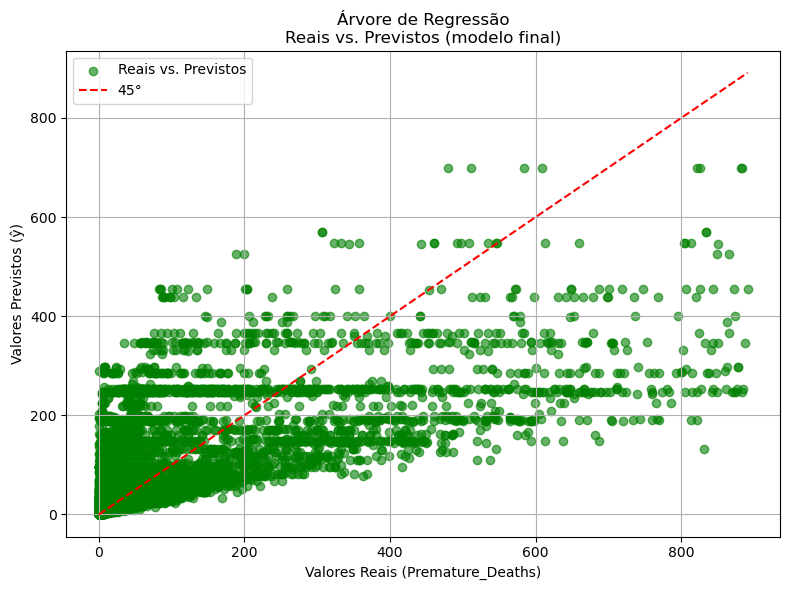

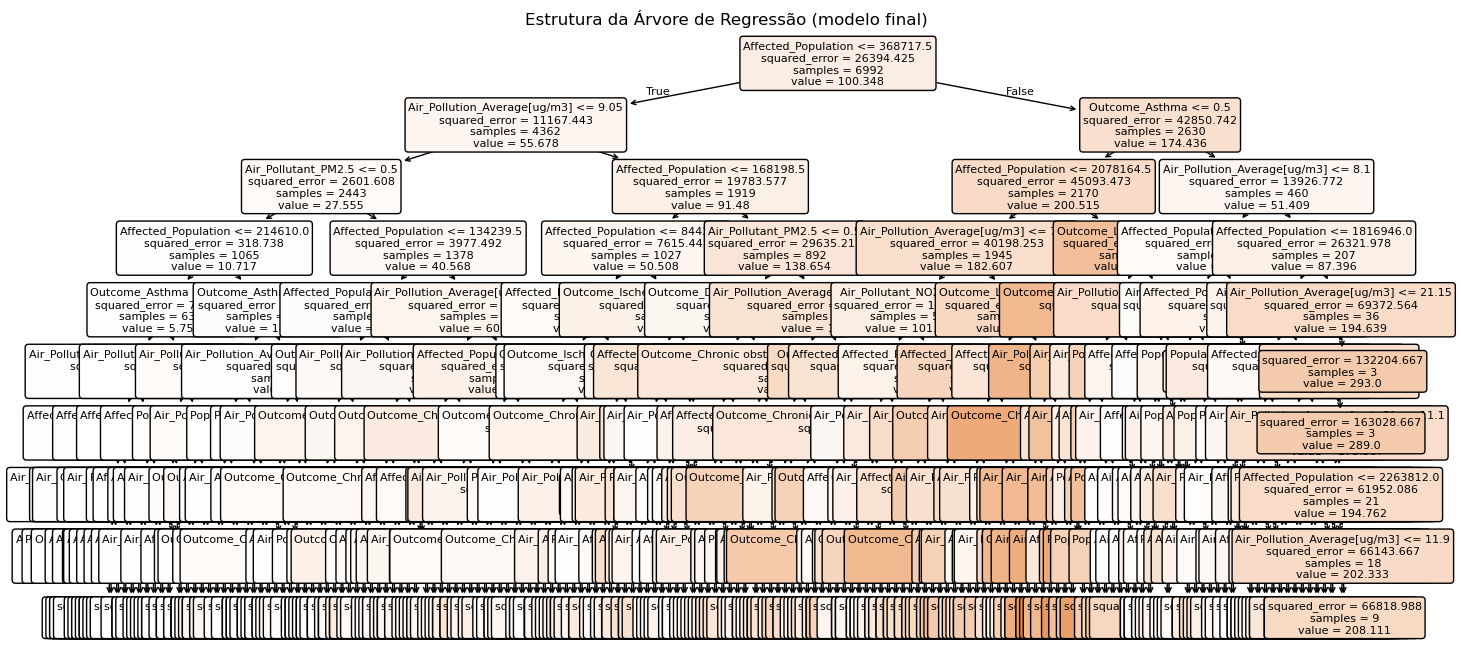

In [8]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("\n==== b) √Årvore de Regress√£o ====\n")

tree_param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# GridSearchCV com valida√ß√£o cruzada (sem necessidade de scaling)
grid_tree = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=tree_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

X = df_southern[features].values # Dados sem scaling
# Listas para armazenar os erros (MAE e RMSE) em cada fold
mae_folds_tree = []
rmse_folds_tree = []

# Vetores para armazenar predi√ß√µes ‚Äúglobais‚Äù
y_pred_full_tree = np.zeros_like(y, dtype=float)
y_true_full_tree = np.zeros_like(y, dtype=float)

# Par√¢metros de exemplo - sinta-se √† vontade para otimizar depois
max_depth = 9
min_samples_split = 5
min_samples_leaf = 1

# Ajustar nos dados sem normaliza√ß√£o
grid_tree.fit(X, y)


# Guardar os melhores par√¢metros encontrados
best_tree_params = grid_tree.best_params_
print("Melhores par√¢metros da √°rvore:", best_tree_params)

# Loop de valida√ß√£o cruzada
for fold_index, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):

    # Preparar conjuntos de treino e teste para este fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Instanciar o regressor de √°rvore para este fold
    model_tree = DecisionTreeRegressor(
         **best_tree_params,
        random_state=42
    )
    
    # Treinar e obter predi√ß√µes
    model_tree.fit(X_train, y_train)
    y_pred = model_tree.predict(X_test)

    # Armazenar predi√ß√£o para c√°lculo global
    y_pred_full_tree[test_index] = y_pred
    y_true_full_tree[test_index] = y_test

    # Calcular e guardar as m√©tricas deste fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_folds_tree.append(mae)
    rmse_folds_tree.append(rmse)

    print(f"Fold {fold_index}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# C√°lculo das m√©tricas m√©dias e globai
mae_media_tree = np.mean(mae_folds_tree)
rmse_media_tree = np.mean(rmse_folds_tree)

mae_global_tree = mean_absolute_error(y_true_full_tree, y_pred_full_tree)
rmse_global_tree = np.sqrt(mean_squared_error(y_true_full_tree, y_pred_full_tree))

print("\n===== Resultados √Årvore de Regress√£o (K-Fold = 5) =====")
print(f"MAE m√©dio nos folds:   {mae_media_tree:.4f}")
print(f"RMSE m√©dio nos folds:  {rmse_media_tree:.4f}")
print("-----")
print(f"MAE global (todos os pontos):   {mae_global_tree:.4f}")
print(f"RMSE global (todos os pontos):  {rmse_global_tree:.4f}")

# Ajustar √°rvore final em 100% dos dados
final_model_tree = DecisionTreeRegressor(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)
final_model_tree.fit(X, y)

# Plot: reais vs. previstos (modelo final)
y_pred_fullmodel_tree = final_model_tree.predict(X)
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_fullmodel_tree, color='green', alpha=0.6, label='Reais vs. Previstos')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='45¬∞')
plt.xlabel("Valores Reais (Premature_Deaths)")
plt.ylabel("Valores Previstos (≈∑)")
plt.title("√Årvore de Regress√£o\nReais vs. Previstos (modelo final)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot da estrutura da √°rvore final
plt.figure(figsize=(16, 8))
plot_tree(
    final_model_tree,
    feature_names=features,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Estrutura da √Årvore de Regress√£o (modelo final)")
plt.show()



==== c) SVM ====

Melhores par√¢metros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Fold 1: MAE = 69.8174, RMSE = 138.9960
Fold 2: MAE = 69.7657, RMSE = 143.3960
Fold 3: MAE = 69.7478, RMSE = 138.7744
Fold 4: MAE = 75.7272, RMSE = 151.3239
Fold 5: MAE = 73.0987, RMSE = 145.9427

===== Resultados SVM (K-Fold = 5) =====
MAE m√©dio nos folds:   71.6314
RMSE m√©dio nos folds:  143.6866
-----
MAE global (todos os pontos):   71.6308
RMSE global (todos os pontos):  143.7622


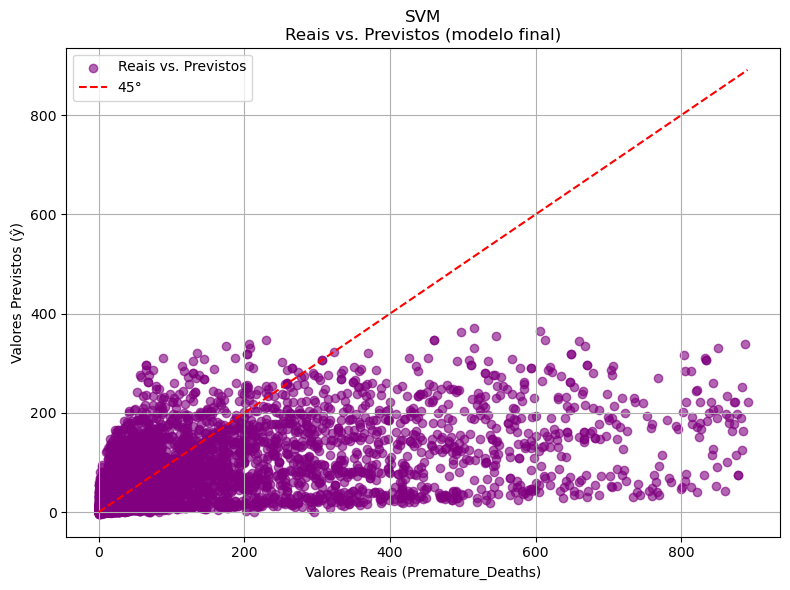

In [10]:
print("\n==== c) SVM ====\n")

# Listas para armazenar os erros (MAE e RMSE) em cada fold
mae_folds_svm = []
rmse_folds_svm = []

# Vetores para armazenar predi√ß√µes ‚Äúglobais‚Äù 
y_pred_full_svm = np.zeros_like(y, dtype=float)
y_true_full_svm = np.zeros_like(y, dtype=float)

# Par√¢metros de exemplo
#kernel_svm = 'poly'
#C_svm = 10
svm_param_grid = [
      {'kernel': ['linear'], 'C': [10]},
    {'kernel': ['rbf'], 'C': [10], 'gamma': ['scale']},
    {'kernel': ['poly'], 'C': [10], 'degree': [3], 'gamma': ['scale']}
]

grid_svm = GridSearchCV(
    SVR(),
    svm_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Ajustar aos dados para obter os melhores par√¢metros
grid_svm.fit(X_scaled, y)
best_svm_params = grid_svm.best_params_
print("Melhores par√¢metros encontrados:", best_svm_params)
# Loop de valida√ß√£o cruzada
for fold_index, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):

    # Dividir em treino e teste para este fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Instanciar modelo SVR para este fold
    model_svm = SVR(**best_svm_params)

    # Treinar e prever
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)

    # Guardar predi√ß√£o para c√°lculo global
    y_pred_full_svm[test_index] = y_pred
    y_true_full_svm[test_index] = y_test


    # Calcular e armazenar as m√©tricas deste fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_folds_svm.append(mae)
    rmse_folds_svm.append(rmse)

    print(f"Fold {fold_index}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")

# C√°lculo das m√©tricas m√©dias e globais 
mae_media_svm = np.mean(mae_folds_svm)
rmse_media_svm = np.mean(rmse_folds_svm)

mae_global_svm = mean_absolute_error(y_true_full_svm, y_pred_full_svm)
rmse_global_svm = np.sqrt(mean_squared_error(y_true_full_svm, y_pred_full_svm))

print("\n===== Resultados SVM (K-Fold = 5) =====")
print(f"MAE m√©dio nos folds:   {mae_media_svm:.4f}")
print(f"RMSE m√©dio nos folds:  {rmse_media_svm:.4f}")
print("-----")
print(f"MAE global (todos os pontos):   {mae_global_svm:.4f}")
print(f"RMSE global (todos os pontos):  {rmse_global_svm:.4f}")

# Ajustar SVR final em 100% dos dados
final_model_svm = SVR(**best_svm_params)
final_model_svm.fit(X_scaled, y)

# Plot: reais vs. previstos (modelo final)
y_pred_fullmodel_svm = final_model_svm.predict(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_fullmodel_svm, color='purple', alpha=0.6, label='Reais vs. Previstos')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='45¬∞')
plt.xlabel("Valores Reais (Premature_Deaths)")
plt.ylabel("Valores Previstos (≈∑)")
plt.title("SVM\nReais vs. Previstos (modelo final)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


==== d) Rede Neuronal MLP ====

Melhores par√¢metros MLP: {'activation': 'relu', 'hidden_layer_sizes': (50, 30), 'max_iter': 5000, 'solver': 'adam'}
Fold 1: MAE = 80.4523, RMSE = 126.2022
Fold 2: MAE = 76.9491, RMSE = 126.1155
Fold 3: MAE = 77.7597, RMSE = 123.4031
Fold 4: MAE = 83.9239, RMSE = 134.6770
Fold 5: MAE = 82.6160, RMSE = 131.6174

===== Resultados Rede Neuronal MLP (K-Fold = 5) =====
MAE m√©dio nos folds:   80.3402
RMSE m√©dio nos folds:  128.4031
-----
MAE global (todos os pontos):   80.3397
RMSE global (todos os pontos):  128.4684


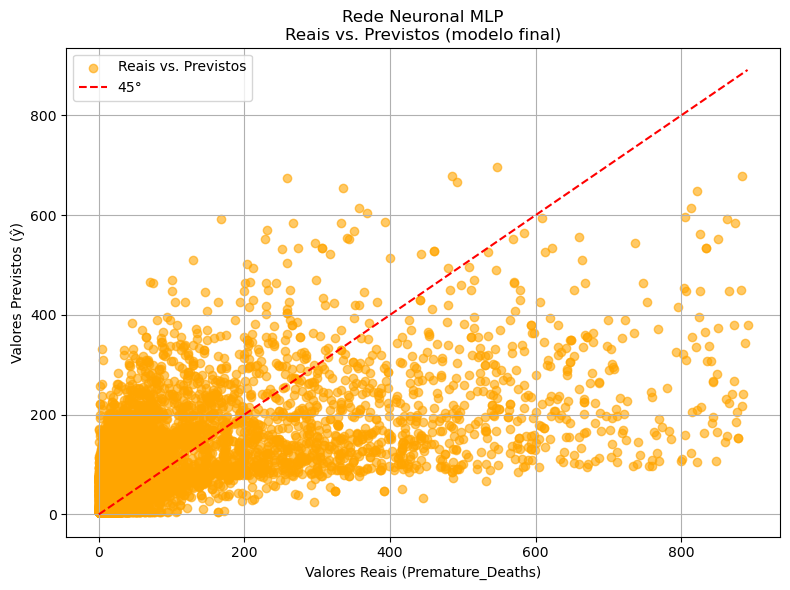

In [11]:
print("\n==== d) Rede Neuronal MLP ====\n")

# Testamos diferentes estruturas de camadas e fun√ß√µes de ativa√ß√£o
mlp_param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (10, 10), (50, 30)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [5000]
}
# Criar e ajustar o GridSearchCV com valida√ß√£o cruzada
grid_mlp = GridSearchCV(
    MLPRegressor(learning_rate='adaptive', early_stopping=True, random_state=42),
    mlp_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Listas para armazenar os erros (MAE e RMSE) em cada fold
mae_folds_mlp = []
rmse_folds_mlp = []

# Vetores para armazenar predi√ß√µes ‚Äúglobais‚Äù
y_pred_full_mlp = np.zeros_like(y, dtype=float)
y_true_full_mlp = np.zeros_like(y, dtype=float)

# Par√¢metros de exemplo
hidden_layers = (4, 5, 6)
activation = 'relu'
solver = 'adam'
max_iter_mlp = 20000

# Ajustar o GridSearch aos dados normalizados
grid_mlp.fit(X_scaled, y)

# Extrair os melhores par√¢metros encontrados
best_mlp_params = grid_mlp.best_params_
print("Melhores par√¢metros MLP:", best_mlp_params)

# Loop de valida√ß√£o cruzada
for fold_index, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    
    # Dividir em treino e teste para este fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Instanciar modelo MLP para este fold
    model_mlp = MLPRegressor(
         **best_mlp_params,
    learning_rate='adaptive',
    early_stopping=True,
    random_state=42
    )

    # Treinar e prever
    model_mlp.fit(X_train, y_train)
    y_pred = model_mlp.predict(X_test)

    # Guardar predi√ß√£o para c√°lculo global
    y_pred_full_mlp[test_index] = y_pred
    y_true_full_mlp[test_index] = y_test

    # Calcular e armazenar as m√©tricas deste fold
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_folds_mlp.append(mae)
    rmse_folds_mlp.append(rmse)

    print(f"Fold {fold_index}: MAE = {mae:.4f}, RMSE = {rmse:.4f}")


# C√°lculo das m√©tricas m√©dias e globais 
mae_media_mlp = np.mean(mae_folds_mlp)
rmse_media_mlp = np.mean(rmse_folds_mlp)

mae_global_mlp = mean_absolute_error(y_true_full_mlp, y_pred_full_mlp)
rmse_global_mlp = np.sqrt(mean_squared_error(y_true_full_mlp, y_pred_full_mlp))

print("\n===== Resultados Rede Neuronal MLP (K-Fold = 5) =====")
print(f"MAE m√©dio nos folds:   {mae_media_mlp:.4f}")
print(f"RMSE m√©dio nos folds:  {rmse_media_mlp:.4f}")
print("-----")
print(f"MAE global (todos os pontos):   {mae_global_mlp:.4f}")
print(f"RMSE global (todos os pontos):  {rmse_global_mlp:.4f}")

# Ajustar MLP final em 100% dos dados
final_model_mlp = MLPRegressor(
    hidden_layer_sizes=hidden_layers,
    activation=activation,
    solver=solver,
    max_iter=max_iter_mlp,
    learning_rate='adaptive',
    early_stopping=True,
    random_state=42
)
final_model_mlp.fit(X_scaled, y)

# Plot: reais vs. previstos (modelo final)
y_pred_fullmodel_mlp = final_model_mlp.predict(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_fullmodel_mlp, color='orange', alpha=0.6, label='Reais vs. Previstos')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='45¬∞')
plt.xlabel("Valores Reais (Premature_Deaths)")
plt.ylabel("Valores Previstos (≈∑)")
plt.title("Rede Neuronal MLP\nReais vs. Previstos (modelo final)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# 4.2.4 Comparar resultados obtidos pelos modelos

results = pd.DataFrame([
    {
      'Model': 'Regress√£o Linear M√∫ltipla',
      'MAE mean fold': mae_media_lr,
      'RMSE mean fold': rmse_media_lr,
      'MAE global':    mae_global_lr,
      'RMSE global':   rmse_global_lr
    },
    {
      'Model': '√Årvore de Regress√£o',
      'MAE mean fold': mae_media_tree,
      'RMSE mean fold': rmse_media_tree,
      'MAE global':    mae_global_tree,
      'RMSE global':   rmse_global_tree
    },
    {
      'Model': 'SVM',
      'MAE mean fold': mae_media_svm,
      'RMSE mean fold': rmse_media_svm,
      'MAE global':    mae_global_svm,
      'RMSE global':   rmse_global_svm
    },
    {
      'Model': 'Rede Neuronal MLP',
      'MAE mean fold': mae_media_mlp,
      'RMSE mean fold': rmse_media_mlp,
      'MAE global':    mae_global_mlp,
      'RMSE global':   rmse_global_mlp
    }
])

# exibir em tabela
print(results.to_markdown(index=False))

| Model                     |   MAE mean fold |   RMSE mean fold |   MAE global |   RMSE global |
|:--------------------------|----------------:|-----------------:|-------------:|--------------:|
| Regress√£o Linear M√∫ltipla |         89.8919 |          136.791 |      89.8913 |       136.858 |
| √Årvore de Regress√£o       |         84.7485 |          136.867 |      84.7481 |       136.904 |
| SVM                       |         71.6314 |          143.687 |      71.6308 |       143.762 |
| Rede Neuronal MLP         |         80.3402 |          128.403 |      80.3397 |       128.468 |


In [13]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, ttest_rel, wilcoxon

# Listas de MAE por fold (dos modelos avaliados anteriormente)
mae_lists = [mae_folds_lr, mae_folds_tree, mae_folds_svm, mae_folds_mlp]
model_names = ['Regress√£o Linear', '√Årvore de Regress√£o', 'SVM', 'Rede Neuronal MLP']

# Calcular MAE m√©dio de cada modelo e identificar os dois com melhor desempenho
mae_means = [np.mean(mae) for mae in mae_lists]
sorted_indices = np.argsort(mae_means)
top1_idx, top2_idx = sorted_indices[:2]

top1_name = model_names[top1_idx]
top2_name = model_names[top2_idx]

print("Dois modelos com menor MAE m√©dio:")
print(f"1) {top1_name} ‚Äî MAE m√©dio: {mae_means[top1_idx]:.2f}")
print(f"2) {top2_name} ‚Äî MAE m√©dio: {mae_means[top2_idx]:.2f}")

# Obter os valores de MAE por fold dos dois melhores modelos
mae_model_1 = np.array(mae_lists[top1_idx])
mae_model_2 = np.array(mae_lists[top2_idx])

# Mostrar compara√ß√£o por fold
df_comparacao = pd.DataFrame({
    "Fold": range(1, len(mae_model_1) + 1),
    f"{top1_name} (MAE)": mae_model_1,
    f"{top2_name} (MAE)": mae_model_2
})
print("\nüìä Compara√ß√£o dos MAE por fold:")
print(df_comparacao.to_markdown(index=False))

# Calcular as diferen√ßas por fold
diffs = mae_model_1 - mae_model_2

# Teste de normalidade (Shapiro-Wilk) sobre as diferen√ßas
stat_shapiro, p_shapiro = shapiro(diffs)
print(f"\nüîç Teste de normalidade (Shapiro-Wilk) ‚Äî p-value: {p_shapiro:.4f}")

alpha = 0.05

# Escolher o teste adequado com base na normalidade
if p_shapiro > alpha:
    print("‚úÖ Diferen√ßas seguem uma distribui√ß√£o normal. Aplicar teste t de Student (pareado).")
    stat_test, p_val = ttest_rel(mae_model_1, mae_model_2)
    test_name = "t de Student (pareado)"
else:
    print("‚ùå Diferen√ßas n√£o seguem uma distribui√ß√£o normal. Aplicar teste de Wilcoxon.")
    stat_test, p_val = wilcoxon(mae_model_1, mae_model_2)
    test_name = "Wilcoxon (n√£o param√©trico)"

# Mostrar resultado do teste escolhido
print(f"\nüìà Teste estat√≠stico: {test_name}")
print(f"Estat√≠stica: {stat_test:.4f}")
print(f"P-value:     {p_val:.4f}")

# Conclus√£o
if p_val < alpha:
    print(f"\n‚úÖ Com Œ± = {alpha}, a diferen√ßa √© estatisticamente significativa.")
    melhor = top1_name if mae_means[top1_idx] < mae_means[top2_idx] else top2_name
    print(f"O modelo com melhor desempenho (menor MAE) √©: {melhor}.")
else:
    print(f"\n‚ùå Com Œ± = {alpha}, a diferen√ßa n√£o √© estatisticamente significativa.")
    print(f"Ambos os modelos apresentam desempenho compar√°vel.")


Dois modelos com menor MAE m√©dio:
1) SVM ‚Äî MAE m√©dio: 71.63
2) Rede Neuronal MLP ‚Äî MAE m√©dio: 80.34

üìä Compara√ß√£o dos MAE por fold:
|   Fold |   SVM (MAE) |   Rede Neuronal MLP (MAE) |
|-------:|------------:|--------------------------:|
|      1 |     69.8174 |                   80.4523 |
|      2 |     69.7657 |                   76.9491 |
|      3 |     69.7478 |                   77.7597 |
|      4 |     75.7272 |                   83.9239 |
|      5 |     73.0987 |                   82.616  |

üîç Teste de normalidade (Shapiro-Wilk) ‚Äî p-value: 0.7324
‚úÖ Diferen√ßas seguem uma distribui√ß√£o normal. Aplicar teste t de Student (pareado).

üìà Teste estat√≠stico: t de Student (pareado)
Estat√≠stica: -14.2805
P-value:     0.0001

‚úÖ Com Œ± = 0.05, a diferen√ßa √© estatisticamente significativa.
O modelo com melhor desempenho (menor MAE) √©: SVM.
